In [10]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [11]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [12]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 106.3 GB  | Proc size: 1.2 GB
GPU RAM Free: 15428MB | Used: 742MB | Util   5% | Total 16376MB


In [13]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
        
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [15]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [16]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times = {}
        self.client_metrics = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [17]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [18]:
strategy = FedCustom()
fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-19 09:34:54,200	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 32798821171.0, 'accelerator_type:RTX': 1.0, 'memory': 66530582733.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57904) [Client 5] evaluate, config: {}
(ClientAppActor pid=57904) Epoch 9: train loss 0.035541, accuracy 0.591333 [repeated 2x across cluster]
(ClientAppActor pid=57904) Training time for Client 9: 23.50 seconds
(ClientAppActor pid=20312) [Client 3] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.363507509231567and 4habhhahah
this is tehb mode time [22.36]
This is ths last time not a fantasy 22.627501487731934and 5habhhahah
this is tehb mode time [22.36, 22.63]
This is ths last time not a fantasy 22.43632435798645and 7habhhahah
this is tehb mode time [22.36, 22.63, 22.44]
This is ths last time not a fantasy 22.98514485359192and 6habhhahah
this is tehb mode time [22.36, 22.63, 22.44, 22.99]
This is ths last time not a fantasy 23.502397537231445and 9habhhahah
this is tehb mode time [22.36, 22.63, 22.44, 22.99, 23.5]
This is ths last time not a fantasy 23.816070795059204and 2habhhahah
this is tehb mode time [22.36, 22.63, 22.44, 22.99, 23.5, 23.82]
This is ths last time not a fantasy 22.954785346984863and 0habhhahah
this is tehb mode time [22.36, 22.63, 22.44, 22.99, 23.5, 23.82, 22.95]
This is ths last time not a fantasy 22.714674949645996and 8habhhahah
this is tehb mode time [22.36, 22.63, 22.44, 22.99, 23.5, 23.82, 22.95, 22.71]
This is th

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=9780) [Client 1] evaluate, config: {}
(ClientAppActor pid=9780) Epoch 8: train loss 0.025316, accuracy 0.716000 [repeated 3x across cluster]
(ClientAppActor pid=9780) Training time for Client 3: 21.09 seconds
(ClientAppActor pid=27772) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.689703226089478and 4habhhahah
this is tehb mode time [20.69]
This is ths last time not a fantasy 21.093127727508545and 3habhhahah
this is tehb mode time [20.69, 21.09]
This is ths last time not a fantasy 20.129745721817017and 9habhhahah
this is tehb mode time [20.69, 21.09, 20.13]
This is ths last time not a fantasy 20.086852073669434and 2habhhahah
this is tehb mode time [20.69, 21.09, 20.13, 20.09]
This is ths last time not a fantasy 20.086134672164917and 5habhhahah
this is tehb mode time [20.69, 21.09, 20.13, 20.09, 20.09]
This is ths last time not a fantasy 19.780405521392822and 0habhhahah
this is tehb mode time [20.69, 21.09, 20.13, 20.09, 20.09, 19.78]
This is ths last time not a fantasy 21.320987224578857and 1habhhahah
this is tehb mode time [20.69, 21.09, 20.13, 20.09, 20.09, 19.78, 21.32]
This is ths last time not a fantasy 20.414870023727417and 8habhhahah
this is tehb mode time [20.69, 21.09, 20.13, 20.09, 20.09, 19.78, 21.32, 20.41]
This

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14444) [Client 4] evaluate, config: {}
(ClientAppActor pid=14444) Training time for Client 7: 23.47 seconds
(ClientAppActor pid=14444) Epoch 9: train loss 0.010382, accuracy 0.889333 [repeated 2x across cluster]
(ClientAppActor pid=27772) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.542017459869385and 3habhhahah
this is tehb mode time [20.54]
This is ths last time not a fantasy 23.472421169281006and 7habhhahah
this is tehb mode time [20.54, 23.47]
This is ths last time not a fantasy 19.913288593292236and 9habhhahah
this is tehb mode time [20.54, 23.47, 19.91]
This is ths last time not a fantasy 20.89623713493347and 6habhhahah
this is tehb mode time [20.54, 23.47, 19.91, 20.9]
This is ths last time not a fantasy 21.9578914642334and 5habhhahah
this is tehb mode time [20.54, 23.47, 19.91, 20.9, 21.96]
This is ths last time not a fantasy 20.23505735397339and 8habhhahah
this is tehb mode time [20.54, 23.47, 19.91, 20.9, 21.96, 20.24]
This is ths last time not a fantasy 20.720231533050537and 4habhhahah
this is tehb mode time [20.54, 23.47, 19.91, 20.9, 21.96, 20.24, 20.72]
This is ths last time not a fantasy 22.332255601882935and 0habhhahah
this is tehb mode time [20.54, 23.47, 19.91, 20.9, 21.96, 20.24, 20.72, 22.33]
This is ths l

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6136) [Client 9] evaluate, config: {}
(ClientAppActor pid=6136) Epoch 8: train loss 0.005563, accuracy 0.946667 [repeated 2x across cluster]
(ClientAppActor pid=6136) Training time for Client 1: 21.20 seconds
(ClientAppActor pid=20312) [Client 5] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.3790020942688and 7habhhahah
this is tehb mode time [20.38]
This is ths last time not a fantasy 21.200421810150146and 1habhhahah
this is tehb mode time [20.38, 21.2]
This is ths last time not a fantasy 20.88697862625122and 3habhhahah
this is tehb mode time [20.38, 21.2, 20.89]
This is ths last time not a fantasy 20.241553783416748and 4habhhahah
this is tehb mode time [20.38, 21.2, 20.89, 20.24]
This is ths last time not a fantasy 19.94507622718811and 6habhhahah
this is tehb mode time [20.38, 21.2, 20.89, 20.24, 19.95]
This is ths last time not a fantasy 19.874769687652588and 5habhhahah
this is tehb mode time [20.38, 21.2, 20.89, 20.24, 19.95, 19.87]
This is ths last time not a fantasy 21.36939263343811and 2habhhahah
this is tehb mode time [20.38, 21.2, 20.89, 20.24, 19.95, 19.87, 21.37]
This is ths last time not a fantasy 19.59326195716858and 0habhhahah
this is tehb mode time [20.38, 21.2, 20.89, 20.24, 19.95, 19.87, 21.37, 19.59]
This is ths last 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57904) [Client 4] evaluate, config: {}
(ClientAppActor pid=57904) Training time for Client 9: 21.47 seconds
(ClientAppActor pid=57904) Epoch 8: train loss 0.003717, accuracy 0.966667
(ClientAppActor pid=6136) [Client 6] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.84946846961975and 2habhhahah
this is tehb mode time [19.85]
This is ths last time not a fantasy 20.53610587120056and 7habhhahah
this is tehb mode time [19.85, 20.54]
This is ths last time not a fantasy 20.116736888885498and 5habhhahah
this is tehb mode time [19.85, 20.54, 20.12]
This is ths last time not a fantasy 19.636593103408813and 4habhhahah
this is tehb mode time [19.85, 20.54, 20.12, 19.64]
This is ths last time not a fantasy 21.33565330505371and 8habhhahah
this is tehb mode time [19.85, 20.54, 20.12, 19.64, 21.34]
This is ths last time not a fantasy 21.469820261001587and 9habhhahah
this is tehb mode time [19.85, 20.54, 20.12, 19.64, 21.34, 21.47]
This is ths last time not a fantasy 19.83524513244629and 0habhhahah
this is tehb mode time [19.85, 20.54, 20.12, 19.64, 21.34, 21.47, 19.84]
This is ths last time not a fantasy 20.032870054244995and 6habhhahah
this is tehb mode time [19.85, 20.54, 20.12, 19.64, 21.34, 21.47, 19.84, 20.03]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5108) [Client 5] evaluate, config: {}
(ClientAppActor pid=5108) Epoch 9: train loss 0.002936, accuracy 0.971333 [repeated 3x across cluster]
(ClientAppActor pid=5108) Training time for Client 1: 23.17 seconds
(ClientAppActor pid=23176) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.776821851730347and 8habhhahah
this is tehb mode time [19.78]
This is ths last time not a fantasy 20.00347900390625and 7habhhahah
this is tehb mode time [19.78, 20.0]
This is ths last time not a fantasy 19.84561514854431and 5habhhahah
this is tehb mode time [19.78, 20.0, 19.85]
This is ths last time not a fantasy 21.970471382141113and 4habhhahah
this is tehb mode time [19.78, 20.0, 19.85, 21.97]
This is ths last time not a fantasy 23.17362904548645and 1habhhahah
this is tehb mode time [19.78, 20.0, 19.85, 21.97, 23.17]
This is ths last time not a fantasy 19.81037664413452and 6habhhahah
this is tehb mode time [19.78, 20.0, 19.85, 21.97, 23.17, 19.81]
This is ths last time not a fantasy 19.73843812942505and 9habhhahah
this is tehb mode time [19.78, 20.0, 19.85, 21.97, 23.17, 19.81, 19.74]
This is ths last time not a fantasy 21.80573010444641and 0habhhahah
this is tehb mode time [19.78, 20.0, 19.85, 21.97, 23.17, 19.81, 19.74, 21.81]
This is ths last 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20312) [Client 9] evaluate, config: {}
(ClientAppActor pid=20312) Training time for Client 3: 21.29 seconds
(ClientAppActor pid=20312) Epoch 8: train loss 0.001252, accuracy 0.992000
(ClientAppActor pid=5108) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.499210357666016and 8habhhahah
this is tehb mode time [20.5]
This is ths last time not a fantasy 19.78966760635376and 6habhhahah
this is tehb mode time [20.5, 19.79]
This is ths last time not a fantasy 20.433730125427246and 5habhhahah
this is tehb mode time [20.5, 19.79, 20.43]
This is ths last time not a fantasy 22.43031907081604and 9habhhahah
this is tehb mode time [20.5, 19.79, 20.43, 22.43]
This is ths last time not a fantasy 21.29108238220215and 3habhhahah
this is tehb mode time [20.5, 19.79, 20.43, 22.43, 21.29]
This is ths last time not a fantasy 20.672770500183105and 7habhhahah
this is tehb mode time [20.5, 19.79, 20.43, 22.43, 21.29, 20.67]
This is ths last time not a fantasy 19.964021921157837and 4habhhahah
this is tehb mode time [20.5, 19.79, 20.43, 22.43, 21.29, 20.67, 19.96]
This is ths last time not a fantasy 20.206724405288696and 1habhhahah
this is tehb mode time [20.5, 19.79, 20.43, 22.43, 21.29, 20.67, 19.96, 20.21]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23176) [Client 6] evaluate, config: {}
(ClientAppActor pid=23176) Training time for Client 2: 20.62 seconds
(ClientAppActor pid=23176) Epoch 8: train loss 0.004112, accuracy 0.957111
(ClientAppActor pid=14444) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23176) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.62239646911621and 2habhhahah
this is tehb mode time [20.62]
This is ths last time not a fantasy 19.653053998947144and 3habhhahah
this is tehb mode time [20.62, 19.65]
This is ths last time not a fantasy 20.109437465667725and 7habhhahah
this is tehb mode time [20.62, 19.65, 20.11]
This is ths last time not a fantasy 19.87330174446106and 4habhhahah
this is tehb mode time [20.62, 19.65, 20.11, 19.87]
This is ths last time not a fantasy 19.655970335006714and 9habhhahah
this is tehb mode time [20.62, 19.65, 20.11, 19.87, 19.66]
This is ths last time not a fantasy 21.179320573806763and 0habhhahah
this is tehb mode time [20.62, 19.65, 20.11, 19.87, 19.66, 21.18]
This is ths last time not a fantasy 19.69249129295349and 1habhhahah
this is tehb mode time [20.62, 19.65, 20.11, 19.87, 19.66, 21.18, 19.69]
This is ths last time not a fantasy 20.423619747161865and 5habhhahah
this is tehb mode time [20.62, 19.65, 20.11, 19.87, 19.66, 21.18, 19.69, 20.42]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23176) [Client 0] evaluate, config: {}
(ClientAppActor pid=23176) Training time for Client 6: 21.21 seconds
(ClientAppActor pid=23176) Epoch 8: train loss 0.006118, accuracy 0.933111
(ClientAppActor pid=27772) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.163760900497437and 9habhhahah
this is tehb mode time [20.16]
This is ths last time not a fantasy 19.996387720108032and 0habhhahah
this is tehb mode time [20.16, 20.0]
This is ths last time not a fantasy 20.21781301498413and 7habhhahah
this is tehb mode time [20.16, 20.0, 20.22]
This is ths last time not a fantasy 20.163602352142334and 5habhhahah
this is tehb mode time [20.16, 20.0, 20.22, 20.16]
This is ths last time not a fantasy 21.214035749435425and 6habhhahah
this is tehb mode time [20.16, 20.0, 20.22, 20.16, 21.21]
This is ths last time not a fantasy 19.918922424316406and 4habhhahah
this is tehb mode time [20.16, 20.0, 20.22, 20.16, 21.21, 19.92]
This is ths last time not a fantasy 19.790510177612305and 1habhhahah
this is tehb mode time [20.16, 20.0, 20.22, 20.16, 21.21, 19.92, 19.79]
This is ths last time not a fantasy 21.006341457366943and 8habhhahah
this is tehb mode time [20.16, 20.0, 20.22, 20.16, 21.21, 19.92, 19.79, 21.01]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14444) [Client 3] evaluate, config: {}
(ClientAppActor pid=14444) Epoch 8: train loss 0.002166, accuracy 0.977333 [repeated 3x across cluster]
(ClientAppActor pid=14444) Training time for Client 3: 20.83 seconds
(ClientAppActor pid=23176) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 600.91s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05297677588462829
INFO :      		round 2: 0.04040484956502914
INFO :      		round 3: 0.0436235821723938
INFO :      		round 4: 0.05030854411125183
INFO :      		round 5: 0.05598848339319229
INFO :      		round 6: 0.062229702091217046
INFO :      		round 7: 0.0641206289410591
INFO :      		round 8: 0.06423649437427521
INFO :      		round 9: 0.06884168797731399
INFO :      		round 10: 0.0723049328327179
INFO :      


(ClientAppActor pid=20312) [Client 1] evaluate, config: {} [repeated 5x across cluster]


History (loss, distributed):
	round 1: 0.05297677588462829
	round 2: 0.04040484956502914
	round 3: 0.0436235821723938
	round 4: 0.05030854411125183
	round 5: 0.05598848339319229
	round 6: 0.062229702091217046
	round 7: 0.0641206289410591
	round 8: 0.06423649437427521
	round 9: 0.06884168797731399
	round 10: 0.0723049328327179

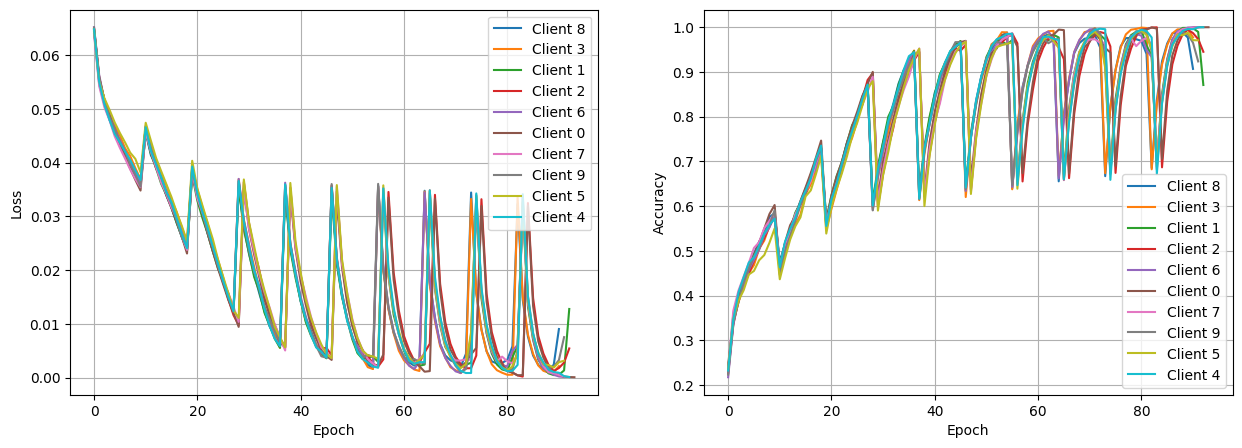

In [19]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")
    

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid()
    

    plt.show()

plot_metrics(strategy.client_metrics)

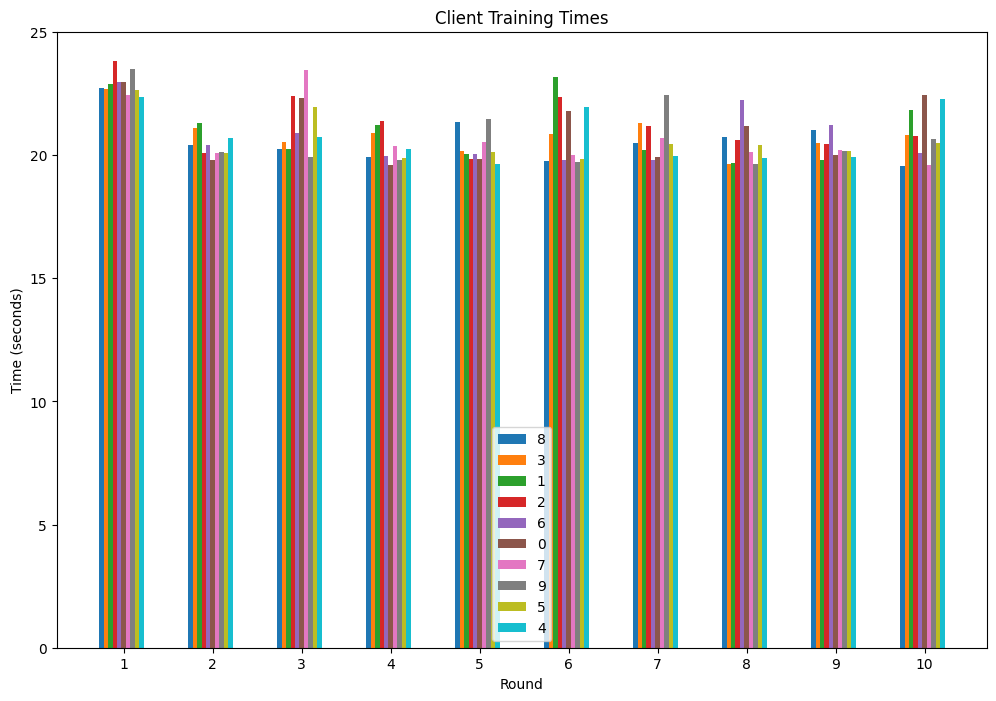

In [20]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()
    
    
    plt.show()

plot_times(strategy.client_training_times)

In [21]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 8 metrics: 91
Client 3 metrics: 91
Client 1 metrics: 93
Client 2 metrics: 93
Client 6 metrics: 92
Client 0 metrics: 94
Client 7 metrics: 92
Client 9 metrics: 92
Client 5 metrics: 92
Client 4 metrics: 93


In [22]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        log(DEBUG, f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [23]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times = {}
        self.client_metrics = {}

    def parse_metrics(self, cid, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=10,
#     config=fl.server.ServerConfig(num_rounds=10),
#     client_resources=client_resources,
# )

In [24]:
strategy_fed_avg = FedAvgCustom()

fl.common.logger.configure(identifier="myflExp", filename="FLLOG.txt")

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-19 09:45:07,110	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 66163153920.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 32641351680.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47500) [Client 6] get_parameters
(ClientAppActor pid=47500) [Client 2] fit, config: {}
(ClientAppActor pid=47500) Epoch 0: train loss 0.065399, accuracy 0.227556
(ClientAppActor pid=47500) Epoch 1: train loss 0.056495, accuracy 0.337556
(ClientAppActor pid=54752) [Client 4] fit, config: {}
(ClientAppActor pid=47500) Epoch 2: train loss 0.051980, accuracy 0.388444
(ClientAppActor pid=54752) Epoch 0: train loss 0.065287, accuracy 0.218667
(ClientAppActor pid=41412) [Client 9] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=20904) Epoch 2: train loss 0.050918, accuracy 0.408222 [repeated 12x across cluster]
(ClientAppActor pid=35128) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=50812) Epoch 4: train loss 0.045401, accuracy 0.480222 [repeated 19x across cluster]
(ClientAppActor pid=47500) [Client 3] fit, config: {}
(ClientAppActor pid=41412) Epoch 5: train loss 0.045224, accuracy 0.474444 [repeated 18x across cluster]
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54752) Epoch 9: train loss 0.036582, accuracy 0.584667 [repeated 3x across cluster]
(ClientAppActor pid=54752) [Client 7] evaluate, config: {}
(ClientAppActor pid=54752) Client 7 loss 0.059888570070266725
(ClientAppActor pid=54752) Client 7 accuracy 0.366
(ClientAppActor pid=45172) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=41412) Client 6 loss 0.05981765365600586 [repeated 4x across cluster]
(ClientAppActor pid=41412) Client 6 accuracy 0.376 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47500) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=47500) Client 2 loss 0.06013200640678406 [repeated 5x across cluster]
(ClientAppActor pid=47500) Client 2 accuracy 0.392 [repeated 5x across cluster]
(ClientAppActor pid=47500) [Client 7] fit, config: {}
(ClientAppActor pid=47500) Epoch 0: train loss 0.048063, accuracy 0.443778
(ClientAppActor pid=41412) [Client 1] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=20904) Epoch 0: train loss 0.049734, accuracy 0.425111 [repeated 11x across cluster]
(ClientAppActor pid=35128) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=36420) Epoch 2: train loss 0.041771, accuracy 0.527556 [repeated 19x across cluster]
(ClientAppActor pid=54752) Epoch 7: train loss 0.029465, accuracy 0.664000 [repeated 19x across cluster]
(ClientAppActor pid=47500) [Client 0] fit, config: {}
(ClientAppActor pid=54752) Epoch 9: train loss 0.023645, accuracy 0.734222 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54752) Epoch 9: train loss 0.024904, accuracy 0.714444 [repeated 5x across cluster]
(ClientAppActor pid=54752) [Client 7] evaluate, config: {}
(ClientAppActor pid=54752) Client 7 loss 0.039284281849861144
(ClientAppActor pid=54752) Client 7 accuracy 0.55
(ClientAppActor pid=20904) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36420) Client 2 loss 0.04499550449848175 [repeated 4x across cluster]
(ClientAppActor pid=36420) Client 2 accuracy 0.532 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47500) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=47500) Client 9 loss 0.0428217705488205 [repeated 5x across cluster]
(ClientAppActor pid=47500) Client 9 accuracy 0.568 [repeated 5x across cluster]
(ClientAppActor pid=47500) [Client 6] fit, config: {}
(ClientAppActor pid=47500) Epoch 0: train loss 0.039984, accuracy 0.546444
(ClientAppActor pid=36420) [Client 4] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=20904) Epoch 2: train loss 0.032224, accuracy 0.634667 [repeated 12x across cluster]
(ClientAppActor pid=54752) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=50812) Epoch 4: train loss 0.024630, accuracy 0.731778 [repeated 20x across cluster]
(ClientAppActor pid=54752) Epoch 4: train loss 0.025176, accuracy 0.717556 [repeated 19x across cluster]
(ClientAppActor pid=35128) Epoch 7: train loss 0.015732, accuracy 0.829333 [repeated 14x across cluster]
(ClientAppActor pid=47500) [

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41412) Epoch 9: train loss 0.010745, accuracy 0.889333 [repeated 5x across cluster]
(ClientAppActor pid=41412) [Client 0] evaluate, config: {}
(ClientAppActor pid=41412) Client 0 loss 0.048926869988441465
(ClientAppActor pid=41412) Client 0 accuracy 0.554
(ClientAppActor pid=41412) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=41412) Client 9 loss 0.046502936720848084 [repeated 4x across cluster]
(ClientAppActor pid=41412) Client 9 accuracy 0.59 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54752) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54752) [Client 7] fit, config: {}
(ClientAppActor pid=54752) Client 3 loss 0.04955646824836731 [repeated 5x across cluster]
(ClientAppActor pid=54752) Client 3 accuracy 0.552 [repeated 5x across cluster]
(ClientAppActor pid=54752) Epoch 0: train loss 0.035979, accuracy 0.598000
(ClientAppActor pid=35128) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50812) Epoch 2: train loss 0.023900, accuracy 0.734000 [repeated 12x across cluster]
(ClientAppActor pid=20904) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=47500) Epoch 4: train loss 0.016570, accuracy 0.824889 [repeated 20x across cluster]
(ClientAppActor pid=50812) Epoch 7: train loss 0.007356, accuracy 0.929333 [repeated 20x across cluster]
(ClientAppActor pid=20904) Epoch 6: train loss 0.009588, accuracy 0.901333 [repeated 15x across cluster]
(ClientAppActor pid=54752) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41412) Epoch 9: train loss 0.004731, accuracy 0.956222 [repeated 5x across cluster]
(ClientAppActor pid=41412) [Client 3] evaluate, config: {}
(ClientAppActor pid=41412) Client 3 loss 0.060935530662536624
(ClientAppActor pid=41412) Client 3 accuracy 0.572
(ClientAppActor pid=35128) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=35128) Client 9 loss 0.05452676367759705 [repeated 4x across cluster]
(ClientAppActor pid=35128) Client 9 accuracy 0.592 [repeated 4x across cluster]
(ClientAppActor pid=50812) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=50812) Client 2 loss 0.06291722512245178 [repeated 4x across cluster]
(ClientAppActor pid=50812) Client 2 accuracy 0.564 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54752) [Client 9] fit, config: {}
(ClientAppActor pid=54752) [Client 0] evaluate, config: {}
(ClientAppActor pid=54752) Client 0 loss 0.05906256318092346
(ClientAppActor pid=54752) Client 0 accuracy 0.558
(ClientAppActor pid=54752) Epoch 0: train loss 0.037204, accuracy 0.602444
(ClientAppActor pid=45172) [Client 4] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=45172) Epoch 0: train loss 0.036124, accuracy 0.616889 [repeated 8x across cluster]
(ClientAppActor pid=41412) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=20904) Epoch 4: train loss 0.011737, accuracy 0.876444 [repeated 20x across cluster]
(ClientAppActor pid=50812) Epoch 7: train loss 0.003405, accuracy 0.971778 [repeated 20x across cluster]
(ClientAppActor pid=54752) [Client 8] fit, config: {}
(ClientAppActor pid=50812) Epoch 9: train loss 0.002695, accuracy 0.978889 [repeated 17x across cluster]
(ClientAppActor pid=50812) [Client 0] fit, config: {}
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50812) [Client 7] evaluate, config: {}
(ClientAppActor pid=50812) Client 7 loss 0.051446718215942384
(ClientAppActor pid=50812) Client 7 accuracy 0.604
(ClientAppActor pid=50812) Epoch 9: train loss 0.004096, accuracy 0.959111
(ClientAppActor pid=36420) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=36420) Client 8 loss 0.05866136622428894 [repeated 4x across cluster]
(ClientAppActor pid=36420) Client 8 accuracy 0.59 [repeated 4x across cluster]
(ClientAppActor pid=20904) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41412) Client 1 loss 0.06720775318145752 [repeated 5x across cluster]
(ClientAppActor pid=41412) Client 1 accuracy 0.54 [repeated 5x across cluster]
(ClientAppActor pid=41412) [Client 3] fit, config: {}
(ClientAppActor pid=41412) [Client 1] evaluate, config: {}
(ClientAppActor pid=41412) Epoch 0: train loss 0.036562, accuracy 0.620667
(ClientAppActor pid=35128) [Client 1] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=35128) Epoch 0: train loss 0.035696, accuracy 0.633111 [repeated 8x across cluster]
(ClientAppActor pid=47500) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=45172) Epoch 4: train loss 0.006818, accuracy 0.934444 [repeated 20x across cluster]
(ClientAppActor pid=36420) Epoch 7: train loss 0.003622, accuracy 0.968667 [repeated 20x across cluster]
(ClientAppActor pid=47500) Epoch 6: train loss 0.003355, accuracy 0.973333 [repeated 19x across cluster]
(ClientAppActor pid=41412) [Client 4] fit, config: {}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=36420) Epoch 9: train loss 0.002740, accuracy 0.976889 [repeated 5x across cluster]
(ClientAppActor pid=36420) [Client 6] evaluate, config: {}
(ClientAppActor pid=36420) Client 6 loss 0.06583725357055664
(ClientAppActor pid=36420) Client 6 accuracy 0.594
(ClientAppActor pid=35128) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54752) Client 3 loss 0.07061439180374146 [repeated 4x across cluster]
(ClientAppActor pid=54752) Client 3 accuracy 0.566 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50812) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=50812) Client 2 loss 0.07185587978363037 [repeated 5x across cluster]
(ClientAppActor pid=50812) Client 2 accuracy 0.572 [repeated 5x across cluster]
(ClientAppActor pid=50812) [Client 9] fit, config: {}
(ClientAppActor pid=50812) Epoch 0: train loss 0.036002, accuracy 0.631333
(ClientAppActor pid=54752) [Client 7] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=54752) Epoch 0: train loss 0.034852, accuracy 0.648889 [repeated 11x across cluster]
(ClientAppActor pid=41412) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=50812) Epoch 5: train loss 0.003677, accuracy 0.971778 [repeated 17x across cluster]
(ClientAppActor pid=35128) Epoch 6: train loss 0.002721, accuracy 0.981333 [repeated 20x across cluster]
(ClientAppActor pid=54752) Epoch 7: train loss 0.003208, accuracy 0.969333 [repeated 16x across cluster]
(ClientAppActor pid=50812) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45172) [Client 3] evaluate, config: {}
(ClientAppActor pid=45172) Client 3 loss 0.07350737619400025
(ClientAppActor pid=45172) Client 3 accuracy 0.562
(ClientAppActor pid=45172) Epoch 9: train loss 0.002466, accuracy 0.980000
(ClientAppActor pid=54752) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=20904) Client 1 loss 0.07563763213157654 [repeated 4x across cluster]
(ClientAppActor pid=20904) Client 1 accuracy 0.536 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41412) [Client 2] fit, config: {}
(ClientAppActor pid=41412) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=41412) Client 8 loss 0.06344926786422729 [repeated 5x across cluster]
(ClientAppActor pid=41412) Client 8 accuracy 0.59 [repeated 5x across cluster]
(ClientAppActor pid=41412) Epoch 0: train loss 0.034476, accuracy 0.653778
(ClientAppActor pid=20904) [Client 4] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=20904) Epoch 0: train loss 0.035360, accuracy 0.655333 [repeated 8x across cluster]
(ClientAppActor pid=47500) [Client 5] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=41412) Epoch 5: train loss 0.002534, accuracy 0.982444 [repeated 21x across cluster]
(ClientAppActor pid=35128) Epoch 6: train loss 0.002916, accuracy 0.974667 [repeated 19x across cluster]
(ClientAppActor pid=41412) [Client 6] fit, config: {}
(ClientAppActor pid=54752) Epoch 7: train loss 0.002742, accuracy 0.972889 [repe

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50812) [Client 7] evaluate, config: {}
(ClientAppActor pid=50812) Client 7 loss 0.060969714403152464
(ClientAppActor pid=50812) Client 7 accuracy 0.614
(ClientAppActor pid=50812) Epoch 9: train loss 0.005456, accuracy 0.942444 [repeated 2x across cluster]
(ClientAppActor pid=54752) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=54752) Client 3 loss 0.07529483246803284 [repeated 4x across cluster]
(ClientAppActor pid=54752) Client 3 accuracy 0.562 [repeated 4x across cluster]
(ClientAppActor pid=50812) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35128) Client 6 loss 0.07381962084770202 [repeated 5x across cluster]
(ClientAppActor pid=35128) Client 6 accuracy 0.552 [repeated 5x across cluster]
(ClientAppActor pid=35128) [Client 4] fit, config: {}
(ClientAppActor pid=35128) [Client 6] evaluate, config: {}
(ClientAppActor pid=35128) Epoch 0: train loss 0.034814, accuracy 0.660667
(ClientAppActor pid=45172) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=20904) Epoch 0: train loss 0.033305, accuracy 0.668222 [repeated 11x across cluster]
(ClientAppActor pid=36420) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=50812) Epoch 4: train loss 0.002780, accuracy 0.980667 [repeated 17x across cluster]
(ClientAppActor pid=20904) Epoch 5: train loss 0.001865, accuracy 0.990222 [repeated 20x across cluster]
(ClientAppActor pid=35128) [Client 1] fit, config: {}
(ClientAppActor pid=41412) Epoch 9: train loss 0.004753, accuracy 0.946444 [repeated 18x across cluster]
(C

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41412) Epoch 9: train loss 0.000143, accuracy 1.000000 [repeated 5x across cluster]
(ClientAppActor pid=41412) [Client 7] evaluate, config: {}
(ClientAppActor pid=41412) Client 7 loss 0.06415315818786621
(ClientAppActor pid=41412) Client 7 accuracy 0.61
(ClientAppActor pid=45172) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=20904) Client 0 loss 0.07518230795860291 [repeated 4x across cluster]
(ClientAppActor pid=20904) Client 0 accuracy 0.55 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35128) [Client 7] fit, config: {}
(ClientAppActor pid=35128) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=35128) Client 9 loss 0.06623702394962311 [repeated 5x across cluster]
(ClientAppActor pid=35128) Client 9 accuracy 0.596 [repeated 5x across cluster]
(ClientAppActor pid=35128) Epoch 0: train loss 0.032061, accuracy 0.687111
(ClientAppActor pid=47500) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=54752) Epoch 2: train loss 0.007769, accuracy 0.917333 [repeated 11x across cluster]
(ClientAppActor pid=36420) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=45172) Epoch 4: train loss 0.001761, accuracy 0.990444 [repeated 17x across cluster]
(ClientAppActor pid=50812) Epoch 5: train loss 0.001065, accuracy 0.996889 [repeated 20x across cluster]
(ClientAppActor pid=35128) [Client 5] fit, config: {}
(ClientAppActor pid=47500) Epoch 8: train loss 0.005310, accuracy 0.944889 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54752) Epoch 9: train loss 0.000120, accuracy 1.000000 [repeated 5x across cluster]
(ClientAppActor pid=54752) [Client 9] evaluate, config: {}
(ClientAppActor pid=54752) Client 9 loss 0.07431346213817597
(ClientAppActor pid=54752) Client 9 accuracy 0.602
(ClientAppActor pid=47500) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50812) Client 3 loss 0.09039150166511535 [repeated 4x across cluster]
(ClientAppActor pid=50812) Client 3 accuracy 0.564 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 635.12s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05997783553600311
INFO :      		round 2: 0.04165357391834259
INFO :      		round 3: 0.04590739011764526
INFO :      		round 4: 0.05555620521306992
INFO :      		round 5: 0.06190264507532119
INFO :      		round 6: 0.06468602471351623
INFO :      		round 7: 0.06736724581718445
INFO :      		round 8: 0.07001143119335175
INFO :      		round 9: 0.07389954068660735
INFO :      		round 10: 0.08213229237794875
INFO :      


History (loss, distributed):
	round 1: 0.05997783553600311
	round 2: 0.04165357391834259
	round 3: 0.04590739011764526
	round 4: 0.05555620521306992
	round 5: 0.06190264507532119
	round 6: 0.06468602471351623
	round 7: 0.06736724581718445
	round 8: 0.07001143119335175
	round 9: 0.07389954068660735
	round 10: 0.08213229237794875

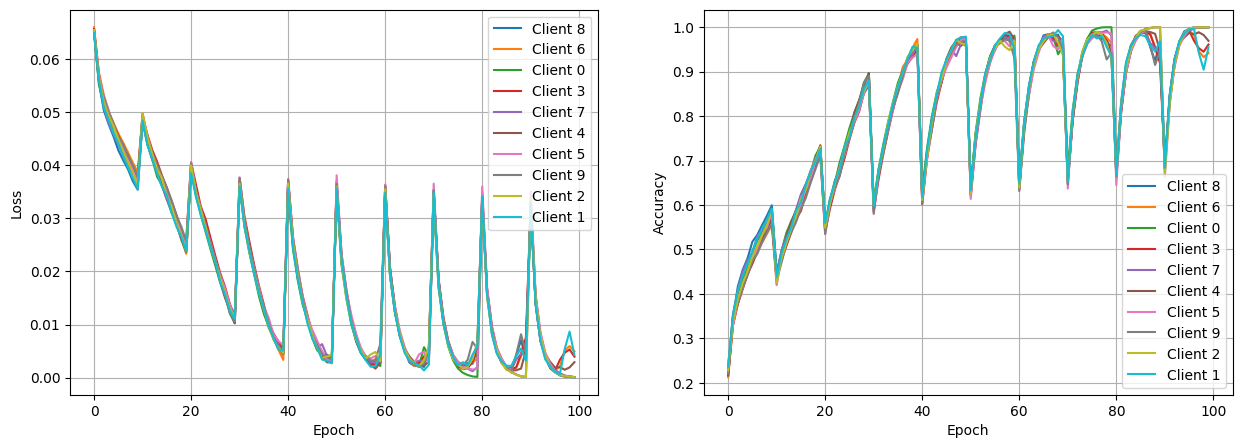

In [27]:
plot_metrics(strategy_fed_avg.client_metrics)

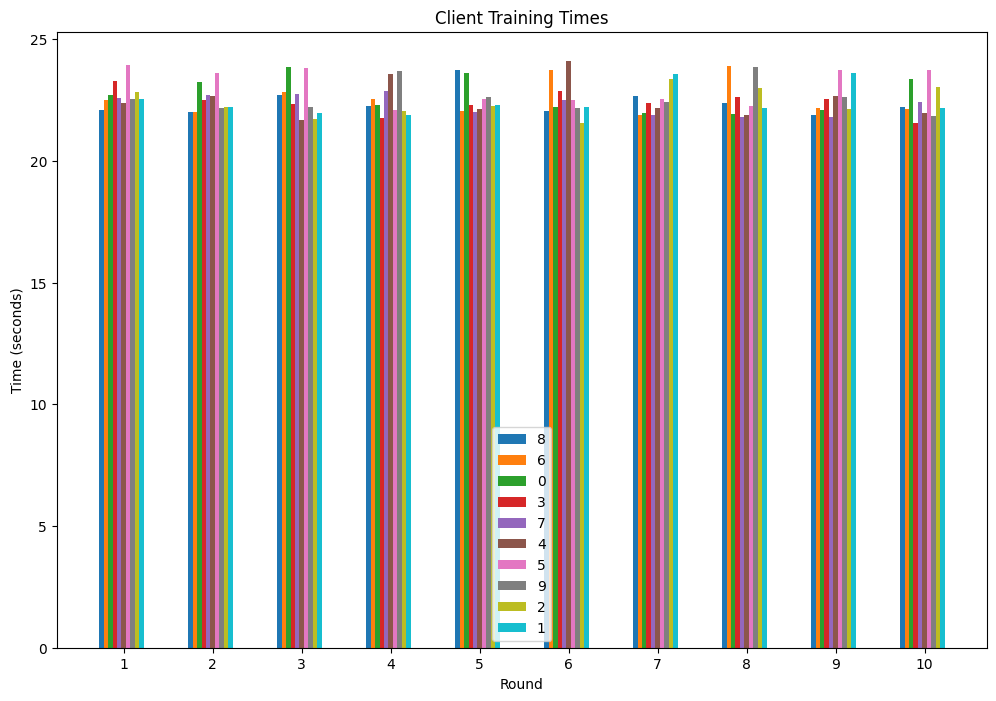

In [28]:
plot_times(strategy_fed_avg.client_training_times)